In [1]:
import itertools
import nltk
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.stats import uniform
import numpy as np

In [2]:
text_data = [['Python', 'and', 'Data Science'],
             ['Python', 'and', 'ML'],
             ['Python', 'and', 'R'],
             ['ML', 'and', 'Data Science'],
             ['R', 'and', 'ML']]

In [3]:
## Creating a single list from multiple lists
data = list(itertools.chain.from_iterable(text_data))

#Create a vocabulary from the data. There are 10 unique words in the corpus
vocab = list(set(data))
vocab

['R', 'and', 'ML', 'Data Science', 'Python']

In [4]:
#Create a vocabulary index
vocab_index = {w:i for i,w in enumerate(vocab)}
vocab_index

{'R': 0, 'and': 1, 'ML': 2, 'Data Science': 3, 'Python': 4}

### lets create a co-occurance matrix for the frequency of bigrams

In [5]:
#Create a co_occurance_matrix with size of vocab
co_occurance_matrix = np.zeros((len(vocab), len(vocab)))

#so lets create bigrams
bigrams = list(nltk.bigrams(data))
bigrams

[('Python', 'and'),
 ('and', 'Data Science'),
 ('Data Science', 'Python'),
 ('Python', 'and'),
 ('and', 'ML'),
 ('ML', 'Python'),
 ('Python', 'and'),
 ('and', 'R'),
 ('R', 'ML'),
 ('ML', 'and'),
 ('and', 'Data Science'),
 ('Data Science', 'R'),
 ('R', 'and'),
 ('and', 'ML')]

In [6]:
#calculating the frequency of the bigrams and converting it to list. It will have the form of ((w1, w2), frequency)
bigram_freq = nltk.FreqDist(bigrams).most_common(len(bigrams))
bigram_freq

[(('Python', 'and'), 3),
 (('and', 'Data Science'), 2),
 (('and', 'ML'), 2),
 (('Data Science', 'Python'), 1),
 (('ML', 'Python'), 1),
 (('and', 'R'), 1),
 (('R', 'ML'), 1),
 (('ML', 'and'), 1),
 (('Data Science', 'R'), 1),
 (('R', 'and'), 1)]

In [7]:
#Iterate through the bigrams and get the index of the corresponding words and update the co-occurance-matrix with the frequency
for bigram in bigram_freq:
    current = bigram[0][1]
    prev = bigram[0][0]
    
    freq = bigram[1]
    pos_current = vocab_index[current]
    pos_prev = vocab_index[prev]
    co_occurance_matrix[pos_prev][pos_current] = freq
#creating a dataframe with the indexes.
#As you can see, (python, is) occured 2 times
matrix = pd.DataFrame(co_occurance_matrix, index=vocab_index, columns=vocab_index)
matrix

,R,and,ML,Data Science,Python
R,0.0,1.0,1.0,0.0,0.0
and,1.0,0.0,2.0,2.0,0.0
ML,0.0,1.0,0.0,0.0,1.0
Data Science,1.0,0.0,0.0,0.0,1.0
Python,0.0,3.0,0.0,0.0,0.0


### Lets create a co-occurance matrix for the window of size 2 (2 words before and 2 words after)

In [8]:
co_occ_mat_1 = np.zeros((len(vocab), len(vocab)))

In [9]:
window_size = 2
co_occ_mat_1 = np.zeros((len(vocab), len(vocab)))
for i,w in enumerate(data):    
    for j in range(max((i-window_size), 0), min(i+window_size+1, len(data))):
        co_occ_mat_1[vocab_index[w], vocab_index[data[j]]] += 1
    
matrix = pd.DataFrame(co_occ_mat_1, index=vocab_index, columns=vocab_index)
matrix

,R,and,ML,Data Science,Python
R,2.0,4.0,2.0,1.0,1.0
and,4.0,5.0,5.0,4.0,5.0
ML,2.0,5.0,3.0,1.0,2.0
Data Science,1.0,4.0,1.0,2.0,2.0
Python,1.0,5.0,2.0,2.0,3.0


In [10]:
#Lets convert the dense matrix to sparse matrix
csr_matrix = sparse.csr_matrix(matrix)
csr_matrix

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [11]:
#you can convert the csr matrix to dense matrix using toarray()
print(csr_matrix.toarray())

[[2. 4. 2. 1. 1.]
 [4. 5. 5. 4. 5.]
 [2. 5. 3. 1. 2.]
 [1. 4. 1. 2. 2.]
 [1. 5. 2. 2. 3.]]


### Lets  create a sparse matrix for co-occurance of words with a window size of 2

In [12]:
co_occ_dict = {}
window_size =2
for i,w in enumerate(data):    
    for j in range(max((i-window_size), 0), min(i+window_size+1, len(data))):
        key  = (vocab_index[w], vocab_index[data[j]])
        if co_occ_dict.get(key):
            co_occ_dict[key] += 1
        else:
            co_occ_dict[key] = 1
    
keys, vals = list(zip(*co_occ_dict.items()))
row_ind, col_ind = list(zip(*keys))
data_csr = sparse.csr_matrix((vals, (row_ind, col_ind)))
data_csr

<5x5 sparse matrix of type '<class 'numpy.int32'>'
	with 25 stored elements in Compressed Sparse Row format>

In [13]:
#converting it to dense matrix
data_csr.toarray()

array([[2, 4, 2, 1, 1],
       [4, 5, 5, 4, 5],
       [2, 5, 3, 1, 2],
       [1, 4, 1, 2, 2],
       [1, 5, 2, 2, 3]], dtype=int32)

## Lets create a co-occurance matrix only for the context words. This will reduce the size of the matrix
#### For our example lets take the 4 most common words from the vocabulary as context words

In [14]:
word_freq = nltk.FreqDist(data).most_common(4)
word_freq

[('and', 5), ('Python', 3), ('ML', 3), ('Data Science', 2)]

In [15]:
context_words = list(zip(*word_freq))[0]
ctx_words_index = {w:i for i,w in enumerate(context_words)}
ctx_words_index

{'and': 0, 'Python': 1, 'ML': 2, 'Data Science': 3}

In [16]:
co_occurance_matrix_2 = np.zeros((len(vocab), len(context_words)))

In [17]:
for bigram in bigram_freq:
    current = bigram[0][0]
    next_w = bigram[0][1]
    
    if next_w in context_words:
        freq = bigram[1]
        pos_current = vocab_index[current]
        pos_ctx_w = ctx_words_index[next_w]
        co_occurance_matrix_2[pos_current][pos_ctx_w] = freq
#creating a dataframe with the indexes.
matrix = pd.DataFrame(co_occurance_matrix_2, index=vocab_index, columns=ctx_words_index)
matrix

,and,Python,ML,Data Science
R,1.0,0.0,1.0,0.0
and,0.0,0.0,2.0,2.0
ML,1.0,1.0,0.0,0.0
Data Science,0.0,1.0,0.0,0.0
Python,3.0,0.0,0.0,0.0


#### Lets define a context window of 2 to find out the co-occurances of the context words for a word

In [18]:
co_occurance_matrix_3 = np.zeros((len(vocab), len(context_words)))

In [19]:
ctx_words_index

{'and': 0, 'Python': 1, 'ML': 2, 'Data Science': 3}

In [20]:
window_size = 2
for i,w in enumerate(data):    
    for j in range(max((i-window_size), 0), min(i+window_size+1, len(data))):
        if i == j:
            continue
        if data[j] in ctx_words_index.keys():
            co_occurance_matrix_3[vocab_index[w], ctx_words_index[data[j]]] += 1
df = pd.DataFrame(co_occurance_matrix_3, index=vocab_index, columns=ctx_words_index)
df

,and,Python,ML,Data Science
R,4.0,1.0,2.0,1.0
and,0.0,5.0,5.0,4.0
ML,5.0,2.0,0.0,1.0
Data Science,4.0,2.0,1.0,0.0
Python,5.0,0.0,2.0,2.0



### Lets create a co-occurance matrix from the data in the form of dataframe. 
https://www.kaggle.com/rtatman/co-occurrence-matrix-plot-in-python

In [21]:
import pandas as pd # dataframes
from io import StringIO # string to data frame
import seaborn as sns # plotting

In [22]:
data_tsv  = StringIO("""city province position
0   Massena     NY  jr
1   Maysville   KY  pm
2   Massena     NY  m
3   Athens      OH  jr
4   Hamilton    OH  sr
5   Englewood   OH  jr
6   Saluda      SC  sr
7   Batesburg   SC  pm
8   Paragould   AR  m""")

df = pd.read_csv(data_tsv, delimiter = r"\s+")

In [23]:
df

,city,province,position
0,Massena,NY,jr
1,Maysville,KY,pm
2,Massena,NY,m
3,Athens,OH,jr
4,Hamilton,OH,sr
5,Englewood,OH,jr
6,Saluda,SC,sr
7,Batesburg,SC,pm
8,Paragould,AR,m


In [24]:
#convert to co-occurance matrix
co_mat = pd.crosstab(df.province, df.position)
co_mat

position,jr,m,pm,sr
province,,,,
AR,0,1,0,0
KY,0,0,1,0
NY,1,1,0,0
OH,2,0,0,1
SC,0,0,1,1


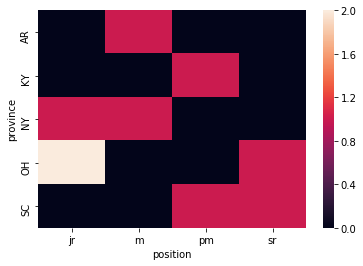

In [25]:
sns.heatmap(co_mat)